In [1]:
import networkx as nx
import pandas as pd
import logging
import numpy as np
import random
import sys
import math
import os
from datetime import date
import matplotlib.pyplot as plt
import pandapower as pp
import seaborn as sns
#import pandapower.topology as top
#import pandapower.plotting as plot
import simbench as sb
import GridCalEngine.api as gce  # For interfacing with the GridCal API
from GridCalEngine.IO.file_handler import FileOpen, FileSave

sys.path.append(os.path.abspath(os.path.join('..', 'src')))
import GC_utils
import GC_PandaPowerImporter
from GC_DistributionNetworkReconfiguration import DistributionNetworkReconfiguration

import logging  
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Create a single plot with lines and two y-axes
def CreatePlot2Lines(data, varx=None, var1 = None, var2 = None, title=None, axs=None, a=0, b=0):
    # Create figure and primary axis
    sns.set_theme(style="whitegrid", palette="pastel")
    
    if varx is None:
        data_varx = data.index
    else:
        data_varx = data[varx]

    if (axs is None):
        fig, ax1 = plt.subplots(figsize=(4, 3))
    else:
       ax1 = axs[a,b]
    # Bar plot (primary axis - left)
    color = 'tab:blue'
    ax1.set_xlabel(varx, fontsize=10)
    ax1.set_ylabel(var1, fontsize=10, color=color)
    line = ax1.plot(data_varx, data[var1], color=color, marker='o', 
                    linewidth=2, markersize=4, label='time (s)')
    ax1.tick_params(axis='y', labelcolor=color)

    # Create secondary axis (right)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel(var2, fontsize=12, color=color)


    line = ax2.plot(data_varx, data[var2], color=color, marker='o', 
                    linewidth=2, markersize=4, label='time (s)')
    ax2.tick_params(axis='y', labelcolor=color)

    # Add title and adjust layout
    if title :
        plt.title(title, fontsize=12, pad=20)

    # Combine legends from both axes
    #lines, labels = ax1.get_legend_handles_labels()
    #lines2, labels2 = ax2.get_legend_handles_labels()
    #ax1.legend(lines + lines2, labels + labels2, loc='upper left')

    # Add grid for primary axis
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

In [3]:
# define a function to apply absolute values
def apply_absolute_values(gridPP, absolute_values_dict, case_or_time_step):
    for elm_param in absolute_values_dict.keys():
        if absolute_values_dict[elm_param].shape[1]:
            elm = elm_param[0]
            param = elm_param[1]
            gridPP[elm].loc[:, param] = absolute_values_dict[elm_param].loc[case_or_time_step]

In [4]:
print('Algorithms to find the optimal distribution network configuration')

logging.basicConfig(
    level=logging.ERROR,  # Set the log level to DEBUG
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',  # Set the log format
    datefmt='%Y-%m-%d %H:%M:%S'  # Set the date format
)

Algorithms to find the optimal distribution network configuration


In [5]:
# Load the Simbench network, eliminate its switches, transformers and double lines
# change the name of the external grid to "grid_ext"
# and set all lines to in_service = True
# export to GridCal

sb_code1 = "1-HVMV-urban-2.203-0-no_sw"
gridPP = sb.get_simbench_net(sb_code1)
gridPP.switch.drop([232,234,236,238,240, 242,244,246], inplace=True)
gridPP.trafo.drop([1,3,4], inplace=True)
gridPP.line.drop(set([123,226,139,140,151,161,166,170,173,178,180,186,187,188,208,223,225,123,226,227,232,228,229,230,231,227,232,233]), inplace=True)
gridPP.ext_grid.at[0,'name']="grid_ext"
gridPP.line['in_service'] = True
pp.runpp(gridPP)
gridGC = GC_PandaPowerImporter.PP2GC(gridPP)
TieLinesName=['1_2_1', '1_24_1', '1_36_1', '1_47_1', '51_52_1', '1_60_1', '1_74_1', '1_85_1', '117_181_1', '171_117_1', '117_125_1', '127_164_1', '121_188_1', '146_147_1', '171_181_1', '116_196_1', '116_154_1']
TieLinesName=['196_165_1', '121_188_1', '127_164_1', '146_147_1', '147_179_1', '147_151_1', '171_181_1', '171_152_1', '116_154_1', '108_109_1', '1_24_1', '1_36_1', '1_85_1', '9_10_1', '51_52_1', '112_113_1', '71_72_1']
TieLinesID=GC_utils.GC_Line_Name2idtag_array(gridGC, TieLinesName)


In [6]:
# PowerFlow execution for validation
TieLinesID=GC_utils.GC_Line_Name2idtag_array(gridGC, TieLinesName)
GC_utils.GC_PowerFlow(gridGC,TieLinesID)

(<GridCalEngine.Simulations.PowerFlow.power_flow_driver.PowerFlowDriver at 0x2338143cec0>,
 np.float64(10.210427627793447))

In [7]:
dnr = DistributionNetworkReconfiguration(gridGC, verbose_logging=logging.ERROR)
try:
    disabled_lines = dnr.Solve(method="Merlin", TieLines=TieLinesID)
    _, loss = GC_utils.GC_PowerFlow(gridGC, config=disabled_lines)
    radiality = GC_utils.CheckRadialConnectedNetwork(gridGC)
    print("Merlin: ", loss, radiality, GC_utils.GC_Line_idtag2name_array(gridGC,disabled_lines))
except:
    print("falla Merlin")        

try:
    disabled_lines = dnr.Solve(method="Baran", TieLines=TieLinesID)
    _, loss = GC_utils.GC_PowerFlow(gridGC, config=None)
    radiality = GC_utils.CheckRadialConnectedNetwork(gridGC)
    print("Baran: ", loss, radiality, GC_utils.GC_Line_idtag2name_array(gridGC,disabled_lines))
except:
    print("falla Baran")        

try:
    disabled_lines = dnr.Solve(method="Salkuti", TieLines=TieLinesID)
    _, loss = GC_utils.GC_PowerFlow(gridGC, config=disabled_lines)
    radiality = GC_utils.CheckRadialConnectedNetwork(gridGC)
    print("Salkuti: ", loss, radiality, GC_utils.GC_Line_idtag2name_array(gridGC,disabled_lines))     
except:
    print("falla Salkuti")        

try:
    disabled_lines = dnr.Solve(method="MSTgreedy", randomMST=False, one=False, current_power=True, algorithm="prim")
    _, loss = GC_utils.GC_PowerFlow(gridGC, config=disabled_lines)
    radiality = GC_utils.CheckRadialConnectedNetwork(gridGC)
    print("MSTgreedy: ", loss, radiality, GC_utils.GC_Line_idtag2name_array(gridGC,disabled_lines))
except:
    print("falla MSTGreedy")        
    
try:
    disabled_lines = dnr.Solve(method="Khalil", NumCandidates=10, fitness_ratio=0.3)
    _, loss = GC_utils.GC_PowerFlow(gridGC, config=disabled_lines)
    radiality = GC_utils.CheckRadialConnectedNetwork(gridGC)
    print("Khalil: ", loss, radiality, GC_utils.GC_Line_idtag2name_array(gridGC,disabled_lines))
except:
    print("falla Khalil")

#try:
disabled_lines = dnr.Solve(method="Jakus", MutationProbability=0.4, PopulationSize=16, Niter=20, ElitePopulation=2, TieLines=TieLinesID, fitness_ratio=0.3, loss_factor=0.02)
_, loss = GC_utils.GC_PowerFlow(gridGC, config=disabled_lines)
radiality = GC_utils.CheckRadialConnectedNetwork(gridGC)
print("Jakus: ", loss, radiality, GC_utils.GC_Line_idtag2name_array(gridGC,disabled_lines))
#except:
#    print("falla Jakus")

try:
    #disabled_lines = dnr.Solve(method="Morton", TieLines=TieLines)
    #_, loss = GC_utils.GC_PowerFlow(gridGC, config=disabled_lines)
    #radiality = GC_utils.CheckRadialConnectedNetwork(gridGC)
    #print("Morton: ", loss, radiality, GC_utils.GC_Line_idtag2name_array(gridGC,disabled_lines))  
    print("Morton is not being tested for the Simbench network due to its size") 
except:
    print("falla Morton")

Merlin:  34.659786237875075 (True, True, True) ['18_19_1', '58_59_1', '60_61_1', '97_98_1', '97_99_1', '113_114_1', '110_11_1', '93_44_1', '171_117_1', '117_191_1', '121_140_1', '137_176_1', '146_147_1', '171_181_1', '196_181_1', '183_189_1', '116_196_1']
Baran:  5.712923837244974 (True, True, True) ['193_117_1', '140_188_1', '127_164_1', '146_183_1', '119_168_1', '147_151_1', '171_181_1', '116_184_1', '143_154_1', '18_19_1', '21_22_1', '93_94_1', '92_93_1', '7_8_1', '54_55_1', '110_111_1', '68_69_1']
Salkuti:  9.60628143997109 (True, True, True) ['196_181_1', '140_188_1', '164_192_1', '147_183_1', '162_179_1', '150_151_1', '171_117_1', '152_184_1', '116_196_1', '109_110_1', '24_25_1', '36_37_1', '85_86_1', '10_11_1', '52_53_1', '111_112_1', '70_71_1']
MSTgreedy:  5.649001656117658 (True, True, True) ['17_18_1', '31_32_1', '58_59_1', '1_68_1', '83_84_1', '109_110_1', '111_112_1', '93_44_1', '147_151_1', '174_186_1', '127_164_1', '171_181_1', '196_181_1', '146_183_1', '116_184_1', '143_

In [8]:
TieLinesID=GC_utils.GC_Line_Name2idtag_array(gridGC, TieLinesName)
_, loss = GC_utils.GC_PowerFlow(gridGC, config=TieLinesID)
radiality = GC_utils.CheckRadialConnectedNetwork(gridGC)
print("Original network: ", loss, radiality )
print("GC loads", np.array([gridGC.loads[i].P for i in range(len(gridGC.loads))]).sum())
print("PP loads-sgen:",gridPP.load.p_mw.sum()-gridPP.res_sgen.p_mw.sum())
print("PP sgen:",gridPP.res_sgen.p_mw.sum())
print("PP ext_grid:",gridPP.res_ext_grid.p_mw.sum())

Original network:  10.210427627793447 (True, True, True)
GC loads -88.27899999999998
PP loads-sgen: -88.279
PP sgen: 609.9989999999999
PP ext_grid: -83.1128976744974


In [9]:
# calculate absolute profiles
profiles = sb.get_absolute_values(gridPP, profiles_instead_of_study_cases=True)

In [10]:
# check that all needed profiles existent
assert not sb.profiles_are_missing(gridPP)

In [11]:
# Define the start date (January 1st of the year)
start_date = '2024-01-01 00:00:00'
# Create a date range with 15-minute intervals for a year
timestamps = pd.date_range(start=start_date, periods=96 * 366, freq='15T')
total_n_steps = len(profiles[('load', 'q_mvar')])
hours = total_n_steps / 4
days = hours / 24
samples_per_day = 4*24
print(f"A total of {total_n_steps} samples which means {hours} hours and {days} days, from {timestamps[0]} to {timestamps[-1]}")

first_day = 180
days = 1
sample_coef = 4 #uses one of every sample_coef samples (i.e if sample_coef=4 uses one of each 4 samples
TimeRange = int(days * samples_per_day/sample_coef)
initial_sample = samples_per_day*first_day


print(f"the selected time span of {days}, taking 1 of each {sample_coef} samples, with a total of {TimeRange} samples to analyze, with initial sample = {initial_sample}")

A total of 35136 samples which means 8784.0 hours and 366.0 days, from 2024-01-01 00:00:00 to 2024-12-31 23:45:00
the selected time span of 1, taking 1 of each 4 samples, with a total of 24 samples to analyze, with initial sample = 17280


In [12]:
# let's calculate the first day of the year (take every fourth time step of the first 96 quarter hour time steps).
time_steps = range(initial_sample,initial_sample+TimeRange+1)  #96*10)
time_steps,time_steps[0], time_steps[-1], time_steps[-1] - time_steps[0]

(range(17280, 17305), 17280, 17304, 24)

In [13]:
# set trafo tap position so that no voltage limits are violated
#gridPP.trafo.tap_pos = 1
previousBestSolution = TieLinesName
# run the time series and store results into a DataFrame
results = pd.DataFrame([], index=time_steps, columns=["GC_loads", "GC_init_losses", "GC_opt_losses_MST", "GC_opt_losses_PSO", "GC_opt_losses_GA", "GC_opt_losses_GA_orig", "GC_radiality"])
for time_step in time_steps:
    apply_absolute_values(gridPP, profiles, time_step)
    gridGC = GC_PandaPowerImporter.PP2GC(gridPP)
    #TieLinesID=GC_utils.GC_Line_Name2idtag_array(gridGC, previousBestSolution)
    TieLinesID=GC_utils.GC_Line_Name2idtag_array(gridGC, TieLinesName)
    OriginalTieLinesID=GC_utils.GC_Line_Name2idtag_array(gridGC, TieLinesName)
    _, loss_init = GC_utils.GC_PowerFlow(gridGC, config=TieLinesID)
    print(f"    initial Losses [{time_step}]: {loss_init}")


    initial Losses [17280]: 0.524978402635414
    initial Losses [17281]: 0.5274349660704665
    initial Losses [17282]: 0.5134969329480332
    initial Losses [17283]: 0.4942780961320115
    initial Losses [17284]: 0.4660157042247721
    initial Losses [17285]: 0.41421060538929655
    initial Losses [17286]: 0.3435443916855223
    initial Losses [17287]: 0.2987281882551699
    initial Losses [17288]: 0.263354664046408
    initial Losses [17289]: 0.25487018826250174
    initial Losses [17290]: 0.24725618620515
    initial Losses [17291]: 0.24551916294172765
    initial Losses [17292]: 0.25360363789306045
    initial Losses [17293]: 0.2610483821297282
    initial Losses [17294]: 0.23748831016520963
    initial Losses [17295]: 0.22748802262390674
    initial Losses [17296]: 0.23976004492641406
    initial Losses [17297]: 0.2149386085669857
    initial Losses [17298]: 0.226456178249632
    initial Losses [17299]: 0.24151495451108349
    initial Losses [17300]: 0.2627422825643997
    initia

In [14]:
# set trafo tap position so that no voltage limits are violated
#gridPP.trafo.tap_pos = 1
previousBestSolution = TieLinesName
# run the time series and store results into a DataFrame
results = pd.DataFrame([], index=time_steps, columns=["GC_loads", "GC_init_losses", "GC_opt_losses_MST", "GC_opt_losses_PSO", "GC_opt_losses_GA", "GC_opt_losses_GA_orig", "GC_radiality"])
for time_step in time_steps:
    apply_absolute_values(gridPP, profiles, time_step)
    gridGC = GC_PandaPowerImporter.PP2GC(gridPP)
    #TieLinesID=GC_utils.GC_Line_Name2idtag_array(gridGC, previousBestSolution)
    TieLinesID=GC_utils.GC_Line_Name2idtag_array(gridGC, TieLinesName)
    OriginalTieLinesID=GC_utils.GC_Line_Name2idtag_array(gridGC, TieLinesName)
    _, loss_init = GC_utils.GC_PowerFlow(gridGC, config=TieLinesID)
    print(f"    initial powerflow: {loss_init}")
    dnr = DistributionNetworkReconfiguration(gridGC, verbose_logging=logging.ERROR)
    disabled_lines_GA = dnr.Solve(method="Jakus", MutationProbability=0.4, PopulationSize=16, Niter=20, ElitePopulation=2, fitness_ratio=1,loss_factor=1, TieLines=TieLinesID)
    disabled_lines_GA_orig = dnr.Solve(method="Jakus", MutationProbability=0.4, PopulationSize=16, Niter=20, ElitePopulation=2, TieLines=OriginalTieLinesID, fitness_ratio=1,loss_factor=1)
    disabled_lines_MST = dnr.Solve(method="MSTgreedy", randomMST=False, one=False, current_power=True, algorithm="prim")
    #disabled_lines_MST = dnr.Solve(method="MSTgreedy", randomMST=False, one=False, current_power=True, algorithm="kruskal")
    disabled_lines_PSO = dnr.Solve(method="Khalil", NumCandidates=10)
    previousBestSolution = GC_utils.GC_Line_idtag2name_array(gridGC, disabled_lines_GA)
    _, loss_opt_MST = GC_utils.GC_PowerFlow(gridGC, config=disabled_lines_MST)
    _, loss_opt_PSO = GC_utils.GC_PowerFlow(gridGC, config=disabled_lines_PSO)
    _, loss_opt_GA = GC_utils.GC_PowerFlow(gridGC, config=disabled_lines_GA)
    _, loss_opt_GA_orig = GC_utils.GC_PowerFlow(gridGC, config=disabled_lines_GA_orig)
    radiality = GC_utils.CheckRadialConnectedNetwork(gridGC)
    results.loc[time_step, "GC_init_losses"] = loss_init
    results.loc[time_step, "GC_opt_losses_MST"] = loss_opt_MST
    results.loc[time_step, "GC_opt_losses_PSO"] = loss_opt_PSO
    results.loc[time_step, "GC_opt_losses_GA"] = loss_opt_GA
    results.loc[time_step, "GC_opt_losses_GA_orig"] = loss_opt_GA_orig
    results.loc[time_step, "GC_radiality"] = str(radiality)
    results.loc[time_step, "GC_loads"] = np.array([gridGC.loads[i].P for i in range(len(gridGC.loads))]).sum()
    print(f"timestep: {time_step}/{time_steps[-1]} ")    

results['GC_init_losses'] = pd.to_numeric(results['GC_init_losses'])
results['GC_opt_losses_MST'] = pd.to_numeric(results['GC_opt_losses_MST'])
results['GC_opt_losses_PSO'] = pd.to_numeric(results['GC_opt_losses_PSO'])
results['GC_opt_losses_GA'] = pd.to_numeric(results['GC_opt_losses_GA'])
results['GC_loads'] = pd.to_numeric(results['GC_loads'])

    initial powerflow: 0.524978402635414
timestep: 17280/17304 
    initial powerflow: 0.5274349660704665
timestep: 17281/17304 
    initial powerflow: 0.5134969329480332
timestep: 17282/17304 
    initial powerflow: 0.4942780961320115
timestep: 17283/17304 
    initial powerflow: 0.4660157042247721
timestep: 17284/17304 
    initial powerflow: 0.41421060538929655
timestep: 17285/17304 
    initial powerflow: 0.3435443916855223
timestep: 17286/17304 
    initial powerflow: 0.2987281882551699
timestep: 17287/17304 
    initial powerflow: 0.263354664046408
timestep: 17288/17304 
    initial powerflow: 0.25487018826250174
timestep: 17289/17304 
    initial powerflow: 0.24725618620515
timestep: 17290/17304 
    initial powerflow: 0.24551916294172765
timestep: 17291/17304 
    initial powerflow: 0.25360363789306045
timestep: 17292/17304 
    initial powerflow: 0.2610483821297282
timestep: 17293/17304 
    initial powerflow: 0.23748831016520963
timestep: 17294/17304 
    initial powerflow: 0

In [15]:
results

,GC_loads,GC_init_losses,GC_opt_losses_MST,GC_opt_losses_PSO,GC_opt_losses_GA,GC_opt_losses_GA_orig,GC_radiality
17280,-29.331601,0.524978,0.458374,0.491374,0.452881,0.461878,"(True, True, True)"
17281,-28.215934,0.527435,0.461149,0.502943,0.427055,0.413812,"(True, True, True)"
17282,-26.391539,0.513497,0.452896,0.496566,0.434720,0.464560,"(True, True, True)"
17283,-26.706057,0.494278,0.439980,0.487026,0.443716,0.403409,"(True, True, True)"
17284,-25.036577,0.466016,0.420734,0.459194,0.399095,0.420506,"(True, True, True)"
17285,-21.401563,0.414211,0.374547,0.414545,0.369323,0.340648,"(True, True, True)"
17286,-13.039116,0.343544,0.325652,0.355916,0.299499,0.297297,"(True, True, True)"
17287,-7.283568,0.298728,0.285692,0.320545,0.254329,0.254329,"(True, True, True)"
17288,-1.607478,0.263355,0.254042,0.285957,0.219759,0.201910,"(True, True, True)"
17289,4.760358,0.254870,0.245330,0.257465,0.210391,0.210391,"(True, True, True)"


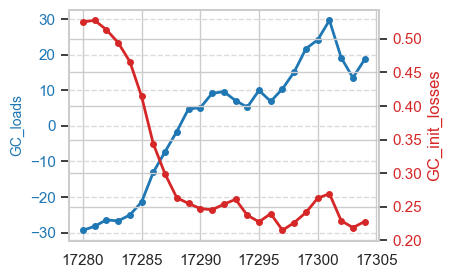

In [16]:
CreatePlot2Lines(data=results, varx=None, var1='GC_loads', var2='GC_init_losses', title=None, axs=None, a=0, b=0)


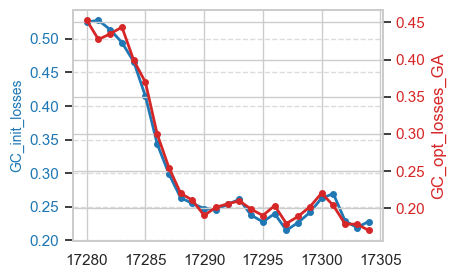

In [17]:
CreatePlot2Lines(data=results, varx=None, var1='GC_init_losses', var2='GC_opt_losses_GA', title=None, axs=None, a=0, b=0)

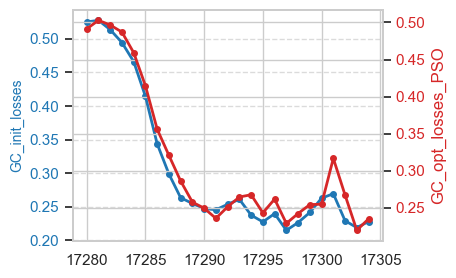

In [18]:
CreatePlot2Lines(data=results, varx=None, var1='GC_init_losses', var2='GC_opt_losses_PSO', title=None, axs=None, a=0, b=0)

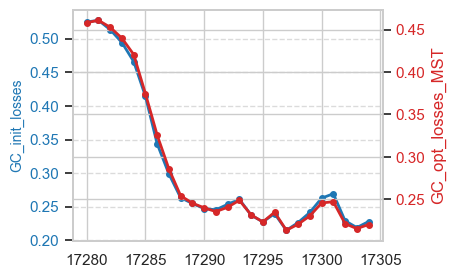

In [19]:
CreatePlot2Lines(data=results, varx=None, var1='GC_init_losses', var2='GC_opt_losses_MST', title=None, axs=None, a=0, b=0)